In [84]:
import os
import tensorflow as tf
from tensorflow import keras
import keras.layers as layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imghdr
%matplotlib inline

In [85]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [86]:
data_dir ='./'

The size of the image is 640 x 480 pixels.


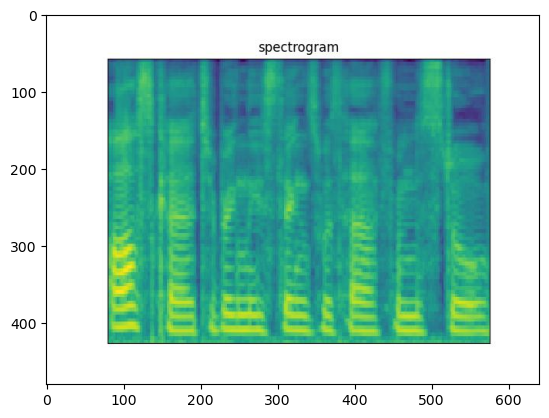

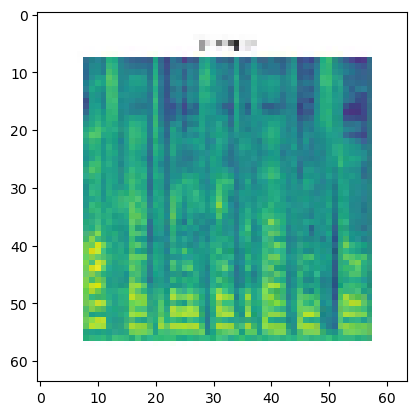

In [87]:
import cv2

# Load the PNG file as a numpy array
img = cv2.imread('original_sound_png/p225/p225_002.png', cv2.IMREAD_UNCHANGED)

# Get the size of the image
height, width = img.shape[:2]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(f"The size of the image is {width} x {height} pixels.")

plt.imshow(img)
plt.show()

resized_image = cv2.resize(img, (64,64))
plt.imshow(resized_image)
plt.show()

In [88]:
resized_image.shape

(64, 64, 3)

In [89]:
os.listdir(data_dir)

['generated',
 'create_csv.py',
 '.DS_Store',
 'CNN.ipynb',
 'generated.zip',
 'wav48',
 'Animals',
 'original_sound_png',
 'audio_classification.ipynb',
 'converted_sound_png',
 'archive.zip',
 'test.ipynb',
 'file_info.csv']

In [90]:
training_data_path = "original_sound_png"
test_data_path = "converted_sound_png"

color_mode = "rgb"
number_color_channels = 3
image_size = (400, 400)
image_shape = image_size + (number_color_channels,)

def get_image_data(data_path, color_mode, image_size, seed = None, subset = None, validation_split = None):
    if subset:
        validation_split = 0.2
    raw_data_set = \
    tf.keras.preprocessing.image_dataset_from_directory(
        data_path,
        color_mode=color_mode,
        image_size=image_size,
        seed=seed,
        validation_split=validation_split, 
        subset=subset
    )
    
    raw_data_set.class_names.sort()
    
    return {
        "data": raw_data_set.cache().prefetch(
        buffer_size = tf.data.experimental.AUTOTUNE
        ),
        "classNames": raw_data_set.class_names
    }

In [91]:
train_set = get_image_data(
    training_data_path,
    color_mode,
    image_size,
    seed = 42,
    subset = "training"
)
validation_set = get_image_data(
    training_data_path,
    color_mode,
    image_size,
    seed = 42,
    subset = "validation"
)
test_set = get_image_data(
    test_data_path,
    color_mode,
    image_size
)

Found 40 files belonging to 4 classes.
Using 32 files for training.
Found 40 files belonging to 4 classes.
Using 8 files for validation.
Found 1240 files belonging to 4 classes.


In [92]:
# Class Sanity Check
equivalence_check = train_set["classNames"] == validation_set["classNames"]
assert_fail_message = "Training and Validation classes should match"
assert(equivalence_check), assert_fail_message
class_names = train_set["classNames"]
number_classes = len(class_names)

In [93]:
model = tf.keras.Sequential([
  layers.Rescaling(1./255, input_shape = image_shape),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(number_classes)
])

In [94]:
model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [95]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 400, 400, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 400, 400, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 200, 200, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 200, 200, 32)      4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 100, 100, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 100, 100, 64)     

In [96]:
epochs = 20
history = model.fit(
  train_set['data'],
  validation_data = validation_set['data'],
  epochs=epochs
)

Epoch 1/20


2023-04-19 14:10:47.391263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 569ms/step - loss: 1.3955 - accuracy: 0.2188 - val_loss: 20.9095 - val_accuracy: 0.1250
Epoch 2/20


2023-04-19 14:10:47.752283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 152ms/step - loss: 12.6089 - accuracy: 0.2812 - val_loss: 15.0288 - val_accuracy: 0.3750
Epoch 3/20
1/1 [==============================] - 0s 141ms/step - loss: 14.6555 - accuracy: 0.2188 - val_loss: 5.9172 - val_accuracy: 0.1250
Epoch 4/20
1/1 [==============================] - 0s 135ms/step - loss: 5.4835 - accuracy: 0.2812 - val_loss: 2.9267 - val_accuracy: 0.1250
Epoch 5/20
1/1 [==============================] - 0s 136ms/step - loss: 2.3194 - accuracy: 0.2812 - val_loss: 2.1288 - val_accuracy: 0.1250
Epoch 6/20
1/1 [==============================] - 0s 135ms/step - loss: 1.6848 - accuracy: 0.2812 - val_loss: 1.8108 - val_accuracy: 0.1250
Epoch 7/20
1/1 [==============================] - 0s 136ms/step - loss: 1.6198 - accuracy: 0.2812 - val_loss: 1.4777 - val_accuracy: 0.1250
Epoch 8/20
1/1 [==============================] - 0s 135ms/step - loss: 1.3892 - accuracy: 0.4062 - val_loss: 1.3592 - val_accuracy: 0.2500
Epoch 9/20
1/1 [============

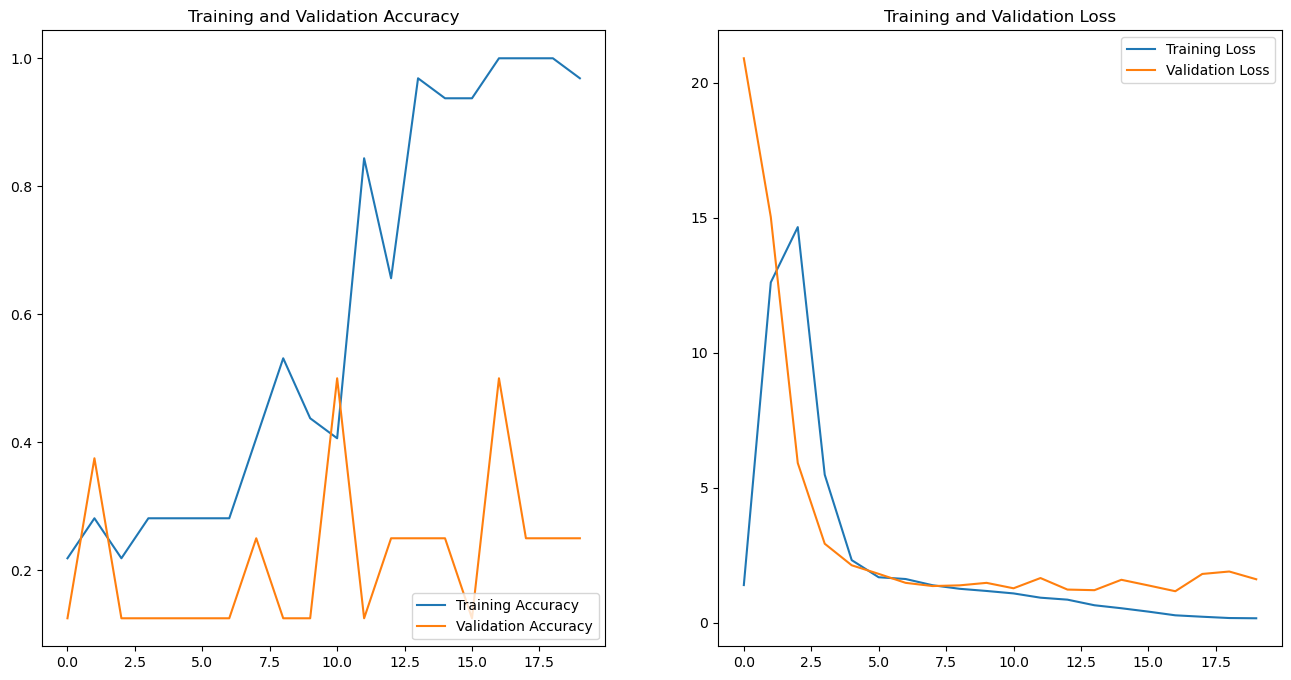

In [97]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [98]:
result = model.evaluate(test_set['data'])

39/39 [==============================] - 2s 51ms/step - loss: 2.2280 - accuracy: 0.3581


In [99]:
print('The classification accuracy on test set is {0}'.format(result[1]))

The classification accuracy on test set is 0.3580645024776459


In [100]:
print(result)

[2.2280426025390625, 0.3580645024776459]


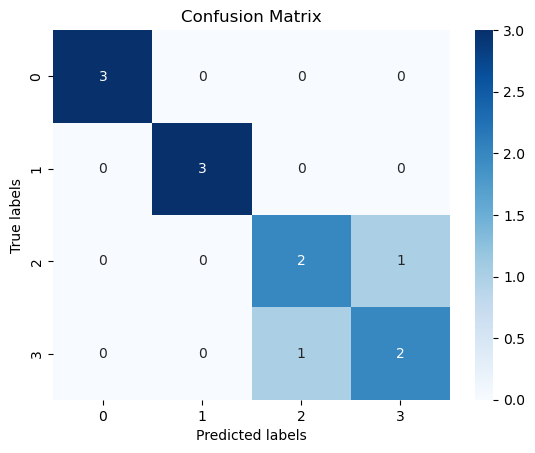

In [102]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# create ground truth and predicted labels
y_true = [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]
y_pred = [0, 1, 2, 3, 0, 1, 2, 2, 0, 1, 3, 3]

# create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# create heatmap using seaborn
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

# add labels to the plot
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

# show the plot
plt.show()
